In [ ]:
from functools import reduce
import gc
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn import datasets, linear_model, metrics

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DSO 522/Project 4/Coffee_Shop_Project.csv')
data

,transaction_id,transaction_date,transaction_time,store_id,store_location,product_id,transaction_qty,unit_price,unit_priceNorm,Total_Bill,...,timeNorm,product_category,product_type,product_detail,Size,Month Name,Day Name,Hour,Month,Day of Week
0,106,1/1/23,11:01:48,0,Astoria,22,1,2.00,-0.519883,2.00,...,-0.627,Coffee,Drip coffee,Our Old Time Diner Blend,Small,January,Sunday,11,1,6
1,107,1/1/23,11:01:58,0,Astoria,38,1,3.75,0.138330,3.75,...,-0.588,Coffee,Barista Espresso,Latte,Not Defined,January,Sunday,11,1,6
2,108,1/1/23,11:01:58,0,Astoria,75,1,3.50,0.044300,3.50,...,-0.627,Bakery,Pastry,Croissant,Not Defined,January,Sunday,11,1,6
3,112,1/1/23,11:08:11,0,Astoria,59,1,4.50,0.420422,4.50,...,0.831,Drinking Chocolate,Hot chocolate,Dark chocolate,Large,January,Sunday,11,1,6
4,114,1/1/23,11:09:01,0,Astoria,59,1,4.50,0.420422,4.50,...,-0.432,Drinking Chocolate,Hot chocolate,Dark chocolate,Large,January,Sunday,11,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149111,149386,30-06-2023,18:28:56,1,Lower Manhattan,22,2,2.00,-0.519883,4.00,...,-0.412,Coffee,Drip coffee,Our Old Time Diner Blend,Small,June,Friday,18,6,4
149112,149387,30-06-2023,18:30:02,1,Lower Manhattan,59,1,4.50,0.420422,4.50,...,-0.369,Drinking Chocolate,Hot chocolate,Dark chocolate,Large,June,Friday,18,6,4
149113,149388,30-06-2023,18:30:02,1,Lower Manhattan,72,1,3.25,-0.049731,3.25,...,-0.627,Bakery,Scone,Ginger Scone,Not Defined,June,Friday,18,6,4
149114,149435,30-06-2023,19:40:09,1,Lower Manhattan,58,2,3.50,0.044300,7.00,...,15.820,Drinking Chocolate,Hot chocolate,Dark chocolate,Regular,June,Friday,19,6,4


In [ ]:
# Function to map month to season
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to create a new 'season' column
data['season'] = data['Month'].apply(get_season)

In [ ]:
data.columns

Index(['transaction_id', 'transaction_date', 'transaction_time', 'store_id',
       'store_location', 'product_id', 'transaction_qty', 'unit_price',
       'unit_priceNorm', 'Total_Bill', 'billNorm',
       'time_between_orders_seconds', 'timeNorm', 'product_category',
       'product_type', 'product_detail', 'Size', 'Month Name', 'Day Name',
       'Hour', 'Month', 'Day of Week', 'season'],
      dtype='object')

In [ ]:
data['store_location'] = data['store_location'].replace("Hell's Kitchen", "Hells kitchen")

In [ ]:
# Perform one-hot encoding
store_dummy = pd.get_dummies(data['store_location'])
category_dummy = pd.get_dummies(data['product_category'])
type_dummy = pd.get_dummies(data['product_type'])
detail_dummy = pd.get_dummies(data['product_detail'])
size_dummy = pd.get_dummies(data['Size'])
DOW_dummy = pd.get_dummies(data['Day of Week'])
season_dummy = pd.get_dummies(data['season'])
month_dummy = pd.get_dummies(data['Month'],prefix = 'Month')
# store_dummy = pd.get_dummies(data['store_id'],prefix = 'store_id')

# Create interaction terms
category_size_interaction = pd.get_dummies(data['product_category'] + '_' + data['Size'], prefix='interaction')
category_detail_interaction = pd.get_dummies(data['product_category'] + '_' + data['product_detail'], prefix='interaction')
# quantity_category_detail_interaction = pd.get_dummies(data['product_category'] + '_' + data['transaction_qty'], prefix='interaction')

#store as integer
store_dummy = store_dummy.astype(int)
category_dummy = category_dummy.astype(int)
type_dummy = type_dummy.astype(int)
detail_dummy = detail_dummy.astype(int)
size_dummy = size_dummy.astype(int)
DOW_dummy = DOW_dummy.astype(int)
season_dummy = season_dummy.astype(int)
month_dummy = month_dummy.astype(int)
category_size_interaction = category_size_interaction.astype(int)
category_detail_interaction = category_detail_interaction.astype(int)
# quantity_category_detail_interaction = quantity_category_detail_interaction.astype(int)

# Concatenate the dummy variables with the original dataframe
data = pd.concat([data, store_dummy,category_dummy,type_dummy,detail_dummy,size_dummy,DOW_dummy,season_dummy,month_dummy,category_size_interaction,category_detail_interaction], axis=1)
data

,transaction_id,transaction_date,transaction_time,store_id,store_location,product_id,transaction_qty,unit_price,unit_priceNorm,Total_Bill,...,interaction_Packaged Chocolate_Dark chocolate,interaction_Packaged Chocolate_Sustainably Grown Organic,interaction_Tea_Earl Grey,interaction_Tea_English Breakfast,interaction_Tea_Lemon Grass,interaction_Tea_Morning Sunrise Chai,interaction_Tea_Peppermint,interaction_Tea_Serenity Green Tea,interaction_Tea_Spicy Eye Opener Chai,interaction_Tea_Traditional Blend Chai
0,106,1/1/23,11:01:48,0,Astoria,22,1,2.00,-0.519883,2.00,...,0,0,0,0,0,0,0,0,0,0
1,107,1/1/23,11:01:58,0,Astoria,38,1,3.75,0.138330,3.75,...,0,0,0,0,0,0,0,0,0,0
2,108,1/1/23,11:01:58,0,Astoria,75,1,3.50,0.044300,3.50,...,0,0,0,0,0,0,0,0,0,0
3,112,1/1/23,11:08:11,0,Astoria,59,1,4.50,0.420422,4.50,...,0,0,0,0,0,0,0,0,0,0
4,114,1/1/23,11:09:01,0,Astoria,59,1,4.50,0.420422,4.50,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149111,149386,30-06-2023,18:28:56,1,Lower Manhattan,22,2,2.00,-0.519883,4.00,...,0,0,0,0,0,0,0,0,0,0
149112,149387,30-06-2023,18:30:02,1,Lower Manhattan,59,1,4.50,0.420422,4.50,...,0,0,0,0,0,0,0,0,0,0
149113,149388,30-06-2023,18:30:02,1,Lower Manhattan,72,1,3.25,-0.049731,3.25,...,0,0,0,0,0,0,0,0,0,0
149114,149435,30-06-2023,19:40:09,1,Lower Manhattan,58,2,3.50,0.044300,7.00,...,0,0,0,0,0,0,0,0,0,0


                            OLS Regression Results                            
Dep. Variable:             Total_Bill   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                 1.087e+05
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:46:08   Log-Likelihood:            -2.6152e+05
No. Observations:              111837   AIC:                         5.230e+05
Df Residuals:                  111834   BIC:                         5.231e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.3659      0.024   -1

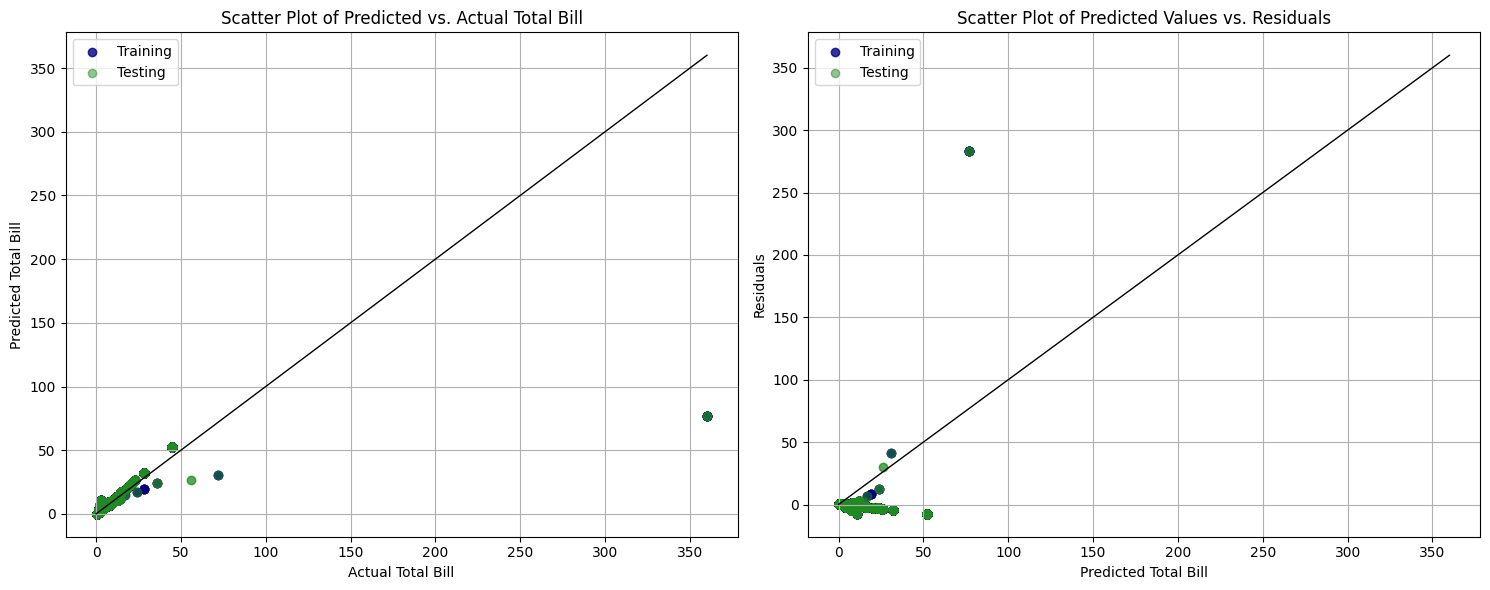

In [50]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Sample data
y = data['Total_Bill']
x = data[['transaction_qty', 'unit_price']]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

# Adding a constant to the predictor variables for training and testing sets
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Building the linear regression model using training data
initial_model = sm.OLS(y_train, X_train).fit()

print(initial_model.summary())

# Obtain predicted values for training and testing sets
predicted_train = initial_model.predict(X_train)
predicted_test = initial_model.predict(X_test)

# Create scatter plot of predicted versus actual values
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot of predicted versus actual values
axs[0].scatter(y_train, predicted_train, color='navy', label='Training', alpha=0.8)  # Adjusted alpha for training set
axs[0].scatter(y_test, predicted_test, color='forestgreen', label='Testing', alpha=0.5)  # Adjusted alpha for testing set
axs[0].set_xlabel('Actual Total Bill')
axs[0].set_ylabel('Predicted Total Bill')
axs[0].set_title('Scatter Plot of Predicted vs. Actual Total Bill')
axs[0].legend()
axs[0].grid(True)

# Scatter plot of predicted values versus residuals
axs[1].scatter(predicted_train, residuals_train, color='navy', label='Training', alpha=0.8)  # Adjusted alpha for training set
axs[1].scatter(predicted_test, residuals_test, color='forestgreen', label='Testing', alpha=0.5)  # Adjusted alpha for testing set
axs[1].set_xlabel('Predicted Total Bill')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Scatter Plot of Predicted Values vs. Residuals')
axs[1].legend()
axs[1].grid(True)

# Plotting diagonal line
xmin = min(min(y_train), min(predicted_train), min(y_test), min(predicted_test))
xmax = max(max(y_train), max(predicted_train), max(y_test), max(predicted_test))
xdiag = np.linspace(xmin, xmax)
ydiag = xdiag
for ax in axs:
    ax.plot(xdiag, ydiag, color="black", linewidth=1)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Building the linear regression model using training data
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

# Calculate R-squared value on testing data
r_squared_sklearn = sklearn_model.score(X_test, y_test)
print('Variance score (R-squared) using scikit-learn: {}'.format(r_squared_sklearn))


Variance score (R-squared) using scikit-learn: 0.6918231745939969


                            OLS Regression Results                            
Dep. Variable:             Total_Bill   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     4145.
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:55:46   Log-Likelihood:            -2.5906e+05
No. Observations:              111837   AIC:                         5.182e+05
Df Residuals:                  111780   BIC:                         5.188e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

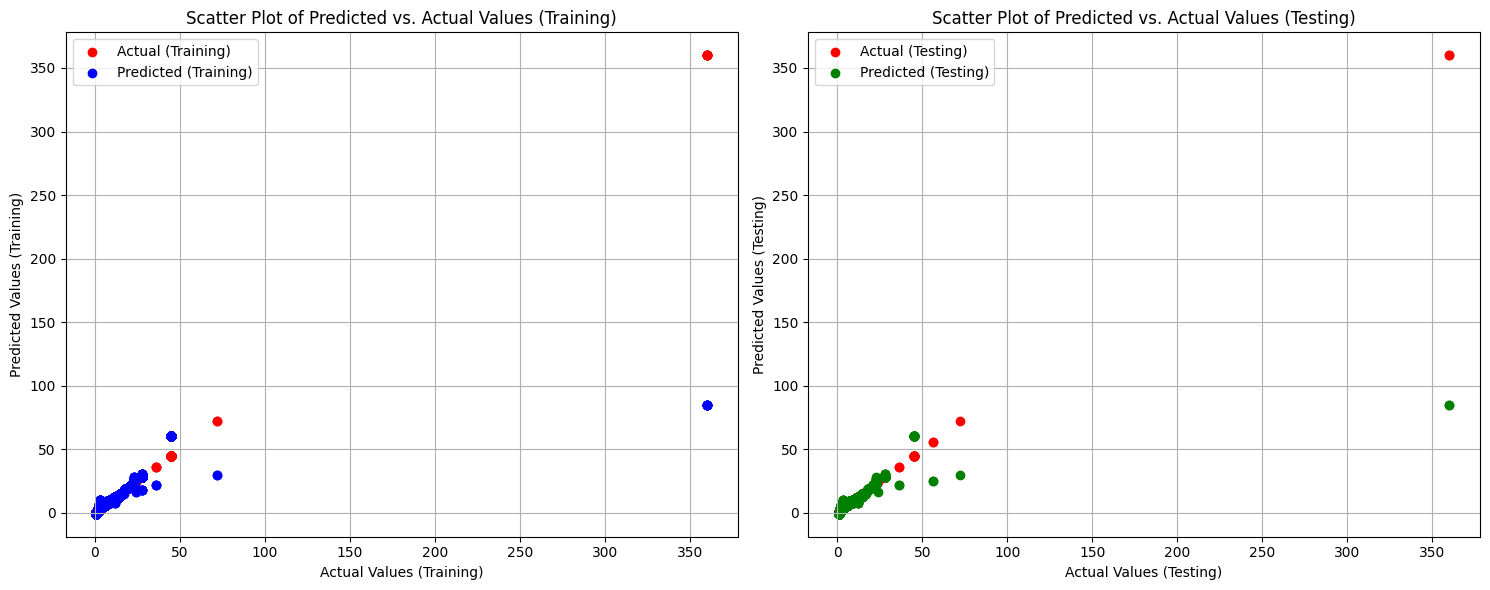

In [53]:
y = data['Total_Bill']
x = data[['transaction_qty','unit_price','Astoria','Hells kitchen','Lower Manhattan',
          'Tea','Coffee','Bakery', 'Drinking Chocolate','Flavours','Loose Tea','Packaged Chocolate','Branded','Coffee beans',
          'Brewed herbal tea','Brewed Black tea','Brewed Green tea','Brewed Chai tea','Drip coffee','Organic brewed coffee','Barista Espresso','Gourmet brewed coffee','Scone','Pastry','Premium brewed coffee',
          'Hot chocolate','Biscotti','Sugar free syrup','Regular syrup','Herbal tea','Black tea','Chai tea','Green tea','Drinking Chocolate','Organic Chocolate','Clothing','Housewares','Espresso Beans',
          'Green beans','Organic Beans','Premium Beans','Gourmet Beans','House blend Beans','Peppermint', 'Lemon Grass', 'Earl Grey', 'English Breakfast', 'Serenity Green Tea','Traditional Blend Chai', 'Our Old Time Diner Blend', 'Brazilian', 'Espresso shot',
          'Ouro Brasileiro shot', 'Columbian Medium Roast', 'Ethiopia', 'Oatmeal Scone', 'Morning Sunrise Chai', 'Almond Croissant', 'Chocolate Croissant', 'Jumbo Savory Scone','Jamaican Coffee River', 'Cappuccino', 'Latte', 'Sustainably Grown Organic',
          'Dark chocolate', 'Croissant', 'Ginger Biscotti', 'Chocolate Chip Biscotti', 'Hazelnut Biscotti', 'Ginger Scone', 'Cranberry Scone', 'Scottish Cream Scone','Sugar Free Vanilla syrup', 'Hazelnut syrup', 'Chocolate syrup', 'Carmel syrup',
          'Spicy Eye Opener Chai', 'Chili Mayan', 'I Need My Bean! T-shirt', 'I Need My Bean! Diner mug', 'I Need My Bean! Latte cup', 'Espresso Roast', 'Primo Espresso Roast', 'Guatemalan Sustainably Grown', 'Organic Decaf Blend',
          'Civet Cat', 'Jamacian Coffee River', 'Brazilian - Organic'
         ]]

#split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Building the linear regression model
model = sm.OLS(y_train,X_train).fit()

# Displaying the model summary
print(model.summary())

#predicted values
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

# Create subplots with same axes for training and testing set
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot of predicted versus actual values for training set
axs[0].scatter(y_train, y_train, color='red', label='Actual (Training)')  # Plotting actual values for training set
axs[0].scatter(y_train, predicted_train, color='blue', label='Predicted (Training)')  # Plotting predicted values for training set
axs[0].set_xlabel('Actual Values (Training)')
axs[0].set_ylabel('Predicted Values (Training)')
axs[0].set_title('Scatter Plot of Predicted vs. Actual Values (Training)')
axs[0].legend()
axs[0].grid(True)

# Scatter plot of predicted versus actual values for testing set
axs[1].scatter(y_test, y_test, color='red', label='Actual (Testing)')  # Plotting actual values for testing set
axs[1].scatter(y_test, predicted_test, color='green', label='Predicted (Testing)')  # Plotting predicted values for testing set
axs[1].set_xlabel('Actual Values (Testing)')
axs[1].set_ylabel('Predicted Values (Testing)')
axs[1].set_title('Scatter Plot of Predicted vs. Actual Values (Testing)')
axs[1].legend()
axs[1].grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Building the linear regression model using training data
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

# Calculate R-squared value on testing data
r_squared_sklearn = sklearn_model.score(X_test, y_test)
print('Variance score (R-squared) using scikit-learn: {}'.format(r_squared_sklearn))


Variance score (R-squared) using scikit-learn: 0.7124329142696333


In [ ]:
y = data['Total_Bill']
x = data[['transaction_qty','unit_price','Astoria','Hells kitchen','Lower Manhattan',
          'Tea','Coffee','Bakery', 'Drinking Chocolate','Flavours','Loose Tea','Packaged Chocolate','Branded','Coffee beans',
          'Brewed herbal tea','Brewed Black tea','Brewed Green tea','Brewed Chai tea','Drip coffee','Organic brewed coffee','Barista Espresso','Gourmet brewed coffee','Scone','Pastry','Premium brewed coffee',
          'Hot chocolate','Biscotti','Sugar free syrup','Regular syrup','Herbal tea','Black tea','Chai tea','Green tea','Drinking Chocolate','Organic Chocolate','Clothing','Housewares','Espresso Beans',
          'Green beans','Organic Beans','Premium Beans','Gourmet Beans','House blend Beans','Peppermint', 'Lemon Grass', 'Earl Grey', 'English Breakfast', 'Serenity Green Tea','Traditional Blend Chai', 'Our Old Time Diner Blend', 'Brazilian', 'Espresso shot',
          'Ouro Brasileiro shot', 'Columbian Medium Roast', 'Ethiopia', 'Oatmeal Scone', 'Morning Sunrise Chai', 'Almond Croissant', 'Chocolate Croissant', 'Jumbo Savory Scone','Jamaican Coffee River', 'Cappuccino', 'Latte', 'Sustainably Grown Organic',
          'Dark chocolate', 'Croissant', 'Ginger Biscotti', 'Chocolate Chip Biscotti', 'Hazelnut Biscotti', 'Ginger Scone', 'Cranberry Scone', 'Scottish Cream Scone','Sugar Free Vanilla syrup', 'Hazelnut syrup', 'Chocolate syrup', 'Carmel syrup',
          'Spicy Eye Opener Chai', 'Chili Mayan', 'I Need My Bean! T-shirt', 'I Need My Bean! Diner mug', 'I Need My Bean! Latte cup', 'Espresso Roast', 'Primo Espresso Roast', 'Guatemalan Sustainably Grown', 'Organic Decaf Blend',
          'Civet Cat', 'Jamacian Coffee River', 'Brazilian - Organic','interaction_Tea_Large', 'interaction_Tea_Regular', 'interaction_Bakery_Almond Croissant',
          'interaction_Bakery_Chocolate Chip Biscotti', 'interaction_Bakery_Chocolate Croissant','interaction_Bakery_Cranberry Scone', 'interaction_Bakery_Croissant', 'interaction_Bakery_Ginger Biscotti',
          'interaction_Bakery_Ginger Scone', 'interaction_Bakery_Hazelnut Biscotti', 'interaction_Bakery_Jumbo Savory Scone','interaction_Bakery_Oatmeal Scone', 'interaction_Bakery_Scottish Cream Scone',
          'interaction_Branded_I Need My Bean! Diner mug', 'interaction_Branded_I Need My Bean! Latte cup','interaction_Branded_I Need My Bean! T-shirt', 'interaction_Coffee beans_Brazilian - Organic',
          'interaction_Coffee beans_Civet Cat', 'interaction_Coffee beans_Columbian Medium Roast','interaction_Coffee beans_Espresso Roast', 'interaction_Coffee beans_Ethiopia','interaction_Coffee beans_Guatemalan Sustainably Grown', 'interaction_Coffee beans_Jamacian Coffee River',
          'interaction_Coffee beans_Organic Decaf Blend', 'interaction_Coffee beans_Our Old Time Diner Blend','interaction_Coffee beans_Primo Espresso Roast', 'interaction_Coffee_Brazilian', 'interaction_Coffee_Cappuccino','interaction_Coffee_Columbian Medium Roast', 'interaction_Coffee_Espresso shot', 'interaction_Coffee_Ethiopia',
          'interaction_Coffee_Jamaican Coffee River', 'interaction_Coffee_Latte', 'interaction_Coffee_Our Old Time Diner Blend','interaction_Coffee_Ouro Brasileiro shot', 'interaction_Drinking Chocolate_Dark chocolate','interaction_Drinking Chocolate_Sustainably Grown Organic', 'interaction_Flavours_Carmel syrup',
          'interaction_Flavours_Chocolate syrup', 'interaction_Flavours_Hazelnut syrup','interaction_Flavours_Sugar Free Vanilla syrup', 'interaction_Loose Tea_Earl Grey','interaction_Loose Tea_English Breakfast', 'interaction_Loose Tea_Lemon Grass',
          'interaction_Loose Tea_Morning Sunrise Chai', 'interaction_Loose Tea_Peppermint',
          'interaction_Loose Tea_Serenity Green Tea', 'interaction_Loose Tea_Spicy Eye Opener Chai',
          'interaction_Loose Tea_Traditional Blend Chai', 'interaction_Packaged Chocolate_Chili Mayan',
          'interaction_Packaged Chocolate_Dark chocolate', 'interaction_Packaged Chocolate_Sustainably Grown Organic',
          'interaction_Tea_Earl Grey', 'interaction_Tea_English Breakfast', 'interaction_Tea_Lemon Grass',
          'interaction_Tea_Morning Sunrise Chai', 'interaction_Tea_Peppermint', 'interaction_Tea_Serenity Green Tea',
          'interaction_Tea_Spicy Eye Opener Chai', 'interaction_Tea_Traditional Blend Chai'
         ]]

#split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Building the linear regression model
model = sm.OLS(y_train,X_train).fit()

# Displaying the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Total_Bill   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3748.
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:56:24   Log-Likelihood:            -2.5902e+05
No. Observations:              111837   AIC:                         5.182e+05
Df Residuals:                  111774   BIC:                         5.188e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Building the linear regression model using training data
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

# Calculate R-squared value on testing data
r_squared_sklearn = sklearn_model.score(X_test, y_test)
print('Variance score (R-squared) using scikit-learn: {}'.format(r_squared_sklearn))


Variance score (R-squared) using scikit-learn: 0.706011564657131
